# Multi-group Agreement (German)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Communities
and Crime dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# German Dataset
Credit application records, where the goal is to predict whether an individual has
low or high credit risk. Sensitive attributes are age and gender. There are two versions of the German
Credit dataset, a “numeric” version which contains binarized versions of most categorical features (with
some removed), and a non-numeric version, which also contains categorical features. We do not use
the “numeric” version of the dataset used by several other works. We found the numeric version of
the dataset to be poorly-documented, lack useful features which were present in the “non-numeric”
version, and contain features which actually mixed multiple variables . Using the non-numeric version,
we extract separate features for sex and marital status (which are combined under a single feature in
the numeric dataset).

COMPAS has $n = 1,000$ instances total, with $d = 22$ features.

In [2]:
root = "./datasets/german"
fp = os.path.join(root, "german.data")
df = pd.read_csv(
    fp, sep=" ", header=None)
df.columns = ["status", "duration", "credit_history",
              "purpose", "credit_amt", "savings_acct_bonds",
              "present_unemployed_since", "installment_rate",
              "per_status_sex", "other_debtors", "pres_res_since",
              "property", "age", "other_installment", "housing",
              "num_exist_credits", "job", "num_ppl", "has_phone",
              "foreign_worker", "target"]

# Code labels as in tfds; see
# https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/structured/german_credit_numeric.py
df["target"] = 2 - df["target"]

# convert per_status_sex into separate columns.
# Sens is 1 if male; else 0.
df["sex"] = df["per_status_sex"].apply(
    lambda x: 1 if x not in ["A92", "A95"] else 0)

# Age sens is 1 if above median age, else 0.
median_age = df["age"].median()
df["age"] = df["age"].apply(lambda x: 1 if x > median_age else 0)
df["single"] = df["per_status_sex"].apply(
    lambda x: 1 if x in ["A93", "A95"] else 0)
df.drop(columns="per_status_sex", inplace=True)

# features 15-23 are categorical/indicators
categorical_columns = [
    "status", "credit_history",
    "purpose", "savings_acct_bonds",
    "present_unemployed_since", "single",
    "other_debtors",
    "property", "other_installment", "housing",
    "job", "has_phone",
    "foreign_worker"]

for colname in categorical_columns:
    df[colname] = df[colname].astype('category')

df.head(5)

,status,duration,credit_history,purpose,credit_amt,savings_acct_bonds,present_unemployed_since,installment_rate,other_debtors,pres_res_since,...,other_installment,housing,num_exist_credits,job,num_ppl,has_phone,foreign_worker,target,sex,single
0,A11,6,A34,A43,1169,A65,A75,4,A101,4,...,A143,A152,2,A173,1,A192,A201,1,1,1
1,A12,48,A32,A43,5951,A61,A73,2,A101,2,...,A143,A152,1,A173,1,A191,A201,0,0,0
2,A14,12,A34,A46,2096,A61,A74,2,A101,3,...,A143,A152,1,A172,2,A191,A201,1,1,1
3,A11,42,A32,A42,7882,A61,A74,2,A103,4,...,A143,A153,1,A173,2,A191,A201,1,1,1
4,A11,24,A33,A40,4870,A61,A73,3,A101,4,...,A143,A153,2,A173,2,A191,A201,0,1,1


In [3]:
X, y = df.drop("target", axis=1), df["target"]
cat_idx = X.select_dtypes(include=["object", "bool", "category"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variale so we have two classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

print("German Credit Shape: {}".format(df.shape))

% examples (y=1): 70.0
% examples (y=0): 30.0
German Credit Shape: (1000, 22)


In [4]:
def german_gp_indices(df, sex_val, age_val):
    if sex_val == "Male":
        return np.where((df['sex'] == 1) & (df['age'] == age_val))
    else:
        return np.where((df['sex'] == 0) & (df['age'] == age_val))

group_names = ["ALL", "M,O", "F,Y", "M,O", "F,Y", "M", "F", "O", "Y"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["Male", "Female"]
age_gps = [1, 0]

# Traditional disjoint groups
for race in race_gps_coarse:
    for age in age_gps:
        indices = german_gp_indices(X, race, age)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['sex'] == 1)
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['sex'] == 0)
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['age'] == 1)
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['age'] == 0)
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [5]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (1000, 60)


In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			800	200
1 (M,O)			312	67
2 (F,Y)			250	61
3 (M,O)			88	17
4 (F,Y)			150	55
5 (M)			562	128
6 (F)			238	72
7 (O)			400	84
8 (Y)			400	116


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.71
P(Y=1 | group 1) = 0.7910447761194029
P(Y=1 | group 2) = 0.6885245901639344
P(Y=1 | group 3) = 0.8235294117647058
P(Y=1 | group 4) = 0.6
P(Y=1 | group 5) = 0.7421875
P(Y=1 | group 6) = 0.6527777777777778
P(Y=1 | group 7) = 0.7976190476190477
P(Y=1 | group 8) = 0.646551724137931


## Utilities for Training/Evaluation

In [8]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [9]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [11]:
# Train LogisticRegression models, one per group
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.25 (+/-0.04330127018922193; n=200)
group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
group 2 (F,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.38181818181818183 (+/-0.09264459123715547; n=55)
group 5 (M): 0.2421875 (+/-0.053550897933028106; n=128)
group 6 (F): 0.3333333333333333 (+/-0.07856742013183862; n=72)
group 7 (O): 0.19047619047619047 (+/-0.06059133431241445; n=84)
group 8 (Y): 0.29310344827586204 (+/-0.05976878104551381; n=116)
PREPEND group 0 (ALL): 0.31 (+/-0.04624932431938871; n=200)
PREPEND group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
PREPEND group 2 (F,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
PREPEND group 3 (M,O): 0.11764705882352941 (+/-0.11051016901502637; n=17)
PREPEND group 4 (F,Y): 0.4 (+/-0.09341987329938276; n=55)
PREPEND group 5 (M): 0.296875 (+/-0.05711012311411502; n=128)
PREPEND group 6 (F): 0.3333333333333

In [12]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(M,O, M) agreement on G1 (M,O):	0.8955223880597015
(M, O) agreement on G1 (M,O):	0.9552238805970149
(M,O, O) agreement on G1 (M,O):	0.9104477611940298
(F,Y, M) agreement on G2 (F,Y):	0.9016393442622951
(M, Y) agreement on G2 (F,Y):	0.8852459016393442
(F,Y, Y) agreement on G2 (F,Y):	0.9508196721311475
(M,O, F) agreement on G3 (M,O):	0.9411764705882353
(F, O) agreement on G3 (M,O):	0.8823529411764706
(M,O, O) agreement on G3 (M,O):	0.9411764705882353
(F,Y, F) agreement on G4 (F,Y):	0.8
(F, Y) agreement on G4 (F,Y):	0.8363636363636363
(F,Y, Y) agreement on G4 (F,Y):	0.8545454545454545

(ALL, M,O) agreement:	0.9
(ALL, F,Y) agreement:	0.88
(ALL, M,O) agreement:	0.79
(ALL, F,Y) agreement:	0.8
(ALL, M) agreement:	0.93
(ALL, F) agreement:	0.87
(ALL, O) agreement:	0.89
(ALL, Y) agreement:	0.875


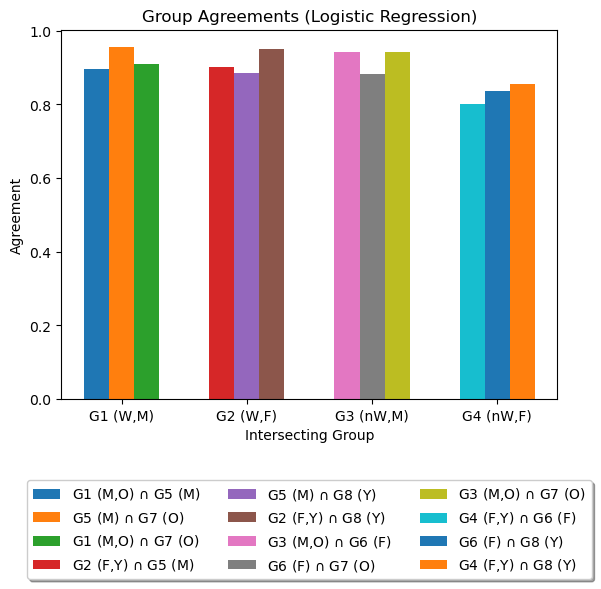

In [13]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_test_err = {}
for g in range(num_groups):
    dt_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, dt_test_err[g], std_err(dt_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.31 (+/-0.04624932431938871; n=200)
group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
group 2 (F,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
group 3 (M,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.34375 (+/-0.059369859974885406; n=128)
group 6 (F): 0.3333333333333333 (+/-0.07856742013183862; n=72)
group 7 (O): 0.25 (+/-0.0668153104781061; n=84)
group 8 (Y): 0.35344827586206895 (+/-0.06276977530849785; n=116)
group 0 (ALL): 0.31 (+/-0.04624932431938871; n=200)
group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
group 2 (F,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
group 3 (M,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.34375 (+/-0.059369859974885406; n=128)
group 6 (F): 0.3333333333333333 (+/-0.07856742013183862; n=72)
group 7 (O): 0.25 (+/-0.0

In [16]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(M,O, M) agreement on G1 (M,O):	0.7611940298507462
(M, O) agreement on G1 (M,O):	0.8955223880597015
(M,O, O) agreement on G1 (M,O):	0.8059701492537313
(F,Y, M) agreement on G2 (F,Y):	0.7049180327868853
(M, Y) agreement on G2 (F,Y):	0.639344262295082
(F,Y, Y) agreement on G2 (F,Y):	0.7049180327868853
(M,O, F) agreement on G3 (M,O):	0.6470588235294118
(F, O) agreement on G3 (M,O):	0.8235294117647058
(M,O, O) agreement on G3 (M,O):	0.7058823529411765
(F,Y, F) agreement on G4 (F,Y):	0.8
(F, Y) agreement on G4 (F,Y):	0.7818181818181819
(F,Y, Y) agreement on G4 (F,Y):	0.7272727272727273

(ALL, M,O) agreement:	0.75
(ALL, F,Y) agreement:	0.815
(ALL, M,O) agreement:	0.72
(ALL, F,Y) agreement:	0.64
(ALL, M) agreement:	0.805
(ALL, F) agreement:	0.735
(ALL, O) agreement:	0.79
(ALL, Y) agreement:	0.795


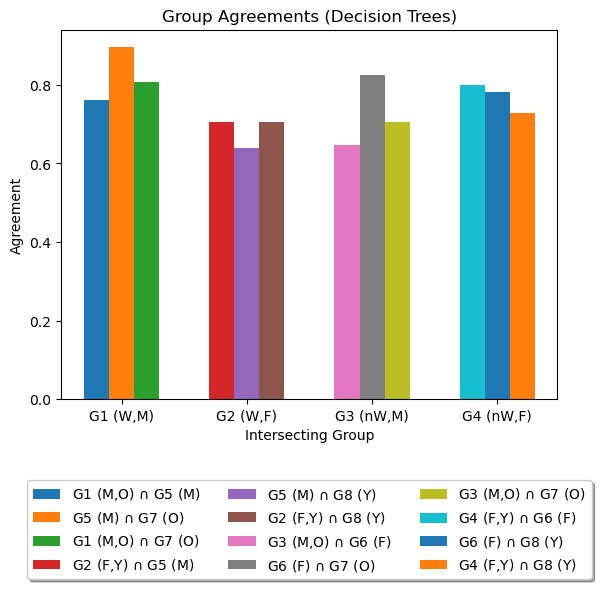

In [17]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Random Forests

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.245 (+/-0.04300872004605578; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (F,Y): 0.19672131147540983 (+/-0.0719795137263977; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.2578125 (+/-0.05467877999675554; n=128)
group 6 (F): 0.2916666666666667 (+/-0.0757549452405258; n=72)
group 7 (O): 0.20238095238095238 (+/-0.0619951807831965; n=84)
group 8 (Y): 0.28448275862068967 (+/-0.0592412249675808; n=116)
group 0 (ALL): 0.245 (+/-0.04300872004605578; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (F,Y): 0.19672131147540983 (+/-0.0719795137263977; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.2578125 (+/-0.05467877999675554; n=128)
group 6 (F): 0.2916666666666667 (+/-0.0757549452405258; n=72)
group 7 (O)

In [20]:
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(M,O, M) agreement on G1 (M,O):	0.8805970149253731
(M, O) agreement on G1 (M,O):	0.9402985074626866
(M,O, O) agreement on G1 (M,O):	0.9104477611940298
(F,Y, M) agreement on G2 (F,Y):	0.8524590163934426
(M, Y) agreement on G2 (F,Y):	0.819672131147541
(F,Y, Y) agreement on G2 (F,Y):	0.9016393442622951
(M,O, F) agreement on G3 (M,O):	1.0
(F, O) agreement on G3 (M,O):	1.0
(M,O, O) agreement on G3 (M,O):	1.0
(F,Y, F) agreement on G4 (F,Y):	0.9272727272727272
(F, Y) agreement on G4 (F,Y):	0.8727272727272727
(F,Y, Y) agreement on G4 (F,Y):	0.8727272727272727

(ALL, M,O) agreement:	0.88
(ALL, F,Y) agreement:	0.895
(ALL, M,O) agreement:	0.835
(ALL, F,Y) agreement:	0.795
(ALL, M) agreement:	0.905
(ALL, F) agreement:	0.91
(ALL, O) agreement:	0.92
(ALL, Y) agreement:	0.895


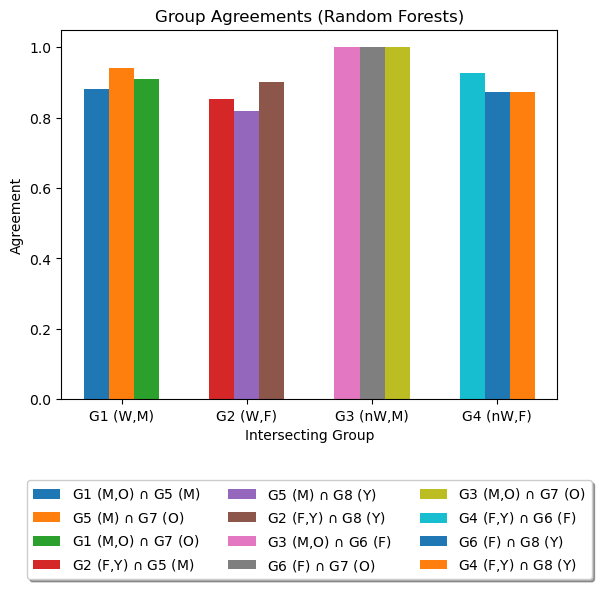

In [21]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, rf_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, rf_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, rf_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, rf_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, rf_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, rf_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, rf_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, rf_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, rf_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, rf_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, rf_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, rf_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Random Forests)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Gradient-Boosted Trees

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err = {}
for g in range(num_groups):
    gb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, gb_test_err[g], std_err(gb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.27 (+/-0.044395945760846225; n=200)
group 1 (M,O): 0.2835820895522388 (+/-0.07787538611340035; n=67)
group 2 (F,Y): 0.3114754098360656 (+/-0.08385359585503979; n=61)
group 3 (M,O): 0.35294117647058826 (+/-0.16391306965158492; n=17)
group 4 (F,Y): 0.3090909090909091 (+/-0.08812258383705454; n=55)
group 5 (M): 0.21875 (+/-0.051674830294230284; n=128)
group 6 (F): 0.2777777777777778 (+/-0.07465053470646806; n=72)
group 7 (O): 0.20238095238095238 (+/-0.0619951807831965; n=84)
group 8 (Y): 0.3017241379310345 (+/-0.06027046547837056; n=116)
group 0 (ALL): 0.27 (+/-0.044395945760846225; n=200)
group 1 (M,O): 0.2835820895522388 (+/-0.07787538611340035; n=67)
group 2 (F,Y): 0.3114754098360656 (+/-0.08385359585503979; n=61)
group 3 (M,O): 0.35294117647058826 (+/-0.16391306965158492; n=17)
group 4 (F,Y): 0.3090909090909091 (+/-0.08812258383705454; n=55)
group 5 (M): 0.21875 (+/-0.051674830294230284; n=128)
group 6 (F): 0.2777777777777778 (+/-0.07465053470646806; n=72)
group 7 (O)

In [24]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(M,O, M) agreement on G1 (M,O):	0.835820895522388
(M, O) agreement on G1 (M,O):	0.9104477611940298
(M,O, O) agreement on G1 (M,O):	0.8059701492537313
(F,Y, M) agreement on G2 (F,Y):	0.8524590163934426
(M, Y) agreement on G2 (F,Y):	0.7868852459016393
(F,Y, Y) agreement on G2 (F,Y):	0.7377049180327869
(M,O, F) agreement on G3 (M,O):	0.8235294117647058
(F, O) agreement on G3 (M,O):	0.8823529411764706
(M,O, O) agreement on G3 (M,O):	0.7058823529411765
(F,Y, F) agreement on G4 (F,Y):	0.7818181818181819
(F, Y) agreement on G4 (F,Y):	0.7272727272727273
(F,Y, Y) agreement on G4 (F,Y):	0.7636363636363637

(ALL, M,O) agreement:	0.815
(ALL, F,Y) agreement:	0.805
(ALL, M,O) agreement:	0.74
(ALL, F,Y) agreement:	0.745
(ALL, M) agreement:	0.855
(ALL, F) agreement:	0.81
(ALL, O) agreement:	0.83
(ALL, Y) agreement:	0.825


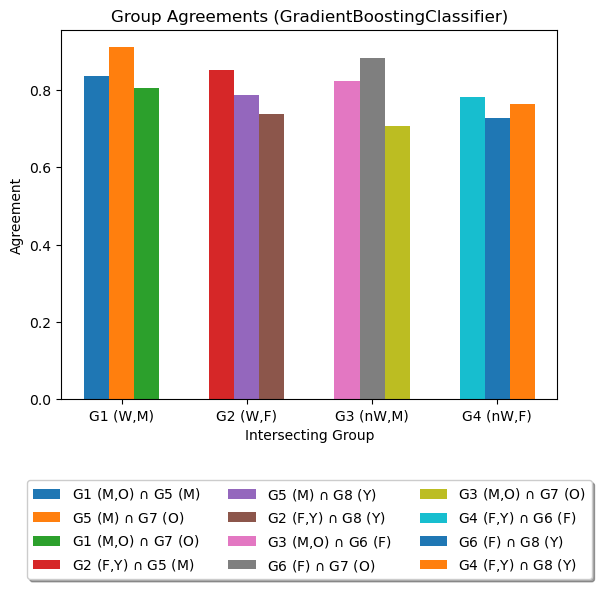

In [25]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (GradientBoostingClassifier)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# XGBoost

In [26]:
from xgboost import XGBClassifier

In [27]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err = {}
for g in range(num_groups):
    xgb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, xgb_test_err[g], std_err(xgb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.24 (+/-0.04270831300812525; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (F,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (M,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.32727272727272727 (+/-0.0894763126106972; n=55)
group 5 (M): 0.234375 (+/-0.052950944186429524; n=128)
group 6 (F): 0.3055555555555556 (+/-0.07677372199896759; n=72)
group 7 (O): 0.19047619047619047 (+/-0.06059133431241445; n=84)
group 8 (Y): 0.3103448275862069 (+/-0.06074691926014174; n=116)
group 0 (ALL): 0.24 (+/-0.04270831300812525; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (F,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (M,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.32727272727272727 (+/-0.0894763126106972; n=55)
group 5 (M): 0.234375 (+/-0.052950944186429524; n=128)
group 6 (F): 0.3055555555555556 (+/-0.07677372199896759; n=72)
group 7 (O): 0

In [28]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(M,O, M) agreement on G1 (M,O):	0.8208955223880597
(M, O) agreement on G1 (M,O):	0.8955223880597015
(M,O, O) agreement on G1 (M,O):	0.9253731343283582
(F,Y, M) agreement on G2 (F,Y):	0.8032786885245902
(M, Y) agreement on G2 (F,Y):	0.7540983606557377
(F,Y, Y) agreement on G2 (F,Y):	0.7540983606557377
(M,O, F) agreement on G3 (M,O):	0.7647058823529411
(F, O) agreement on G3 (M,O):	0.7647058823529411
(M,O, O) agreement on G3 (M,O):	0.7647058823529411
(F,Y, F) agreement on G4 (F,Y):	0.8727272727272727
(F, Y) agreement on G4 (F,Y):	0.8545454545454545
(F,Y, Y) agreement on G4 (F,Y):	0.8727272727272727

(ALL, M,O) agreement:	0.845
(ALL, F,Y) agreement:	0.815
(ALL, M,O) agreement:	0.83
(ALL, F,Y) agreement:	0.755
(ALL, M) agreement:	0.915
(ALL, F) agreement:	0.835
(ALL, O) agreement:	0.885
(ALL, Y) agreement:	0.87


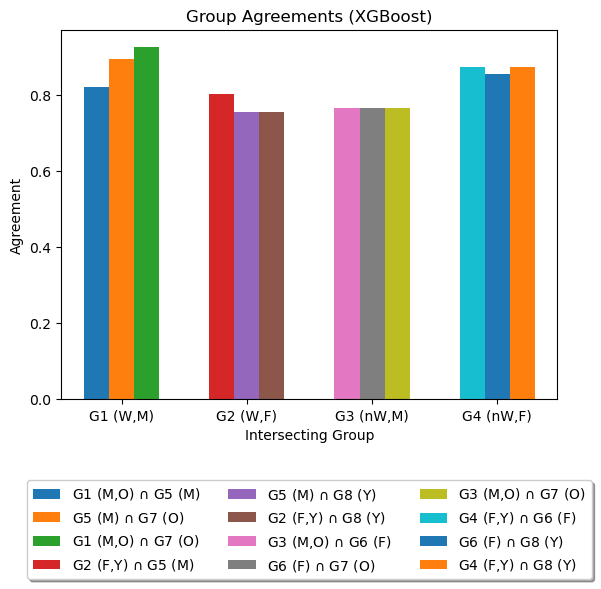

In [29]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        rf_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.245 (+/-0.04300872004605578; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (F,Y): 0.19672131147540983 (+/-0.0719795137263977; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.2578125 (+/-0.05467877999675554; n=128)
group 6 (F): 0.2916666666666667 (+/-0.0757549452405258; n=72)
group 7 (O): 0.20238095238095238 (+/-0.0619951807831965; n=84)
group 8 (Y): 0.28448275862068967 (+/-0.0592412249675808; n=116)
group 0 (ALL): 0.245 (+/-0.04300872004605578; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (F,Y): 0.19672131147540983 (+/-0.0719795137263977; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.2578125 (+/-0.05467877999675554; n=128)
group 6 (F): 0.2916666666666667 (+/-0.0757549452405258; n=72)
group 7 (O)

In [32]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(M,O, M) agreement on G1 (M,O):	0.8805970149253731
(M, O) agreement on G1 (M,O):	0.9402985074626866
(M,O, O) agreement on G1 (M,O):	0.9104477611940298
(F,Y, M) agreement on G2 (F,Y):	0.8524590163934426
(M, Y) agreement on G2 (F,Y):	0.819672131147541
(F,Y, Y) agreement on G2 (F,Y):	0.9016393442622951
(M,O, F) agreement on G3 (M,O):	1.0
(F, O) agreement on G3 (M,O):	1.0
(M,O, O) agreement on G3 (M,O):	1.0
(F,Y, F) agreement on G4 (F,Y):	0.9272727272727272
(F, Y) agreement on G4 (F,Y):	0.8727272727272727
(F,Y, Y) agreement on G4 (F,Y):	0.8727272727272727

(ALL, M,O) agreement:	0.88
(ALL, F,Y) agreement:	0.895
(ALL, M,O) agreement:	0.835
(ALL, F,Y) agreement:	0.795
(ALL, M) agreement:	0.905
(ALL, F) agreement:	0.91
(ALL, O) agreement:	0.92
(ALL, Y) agreement:	0.895


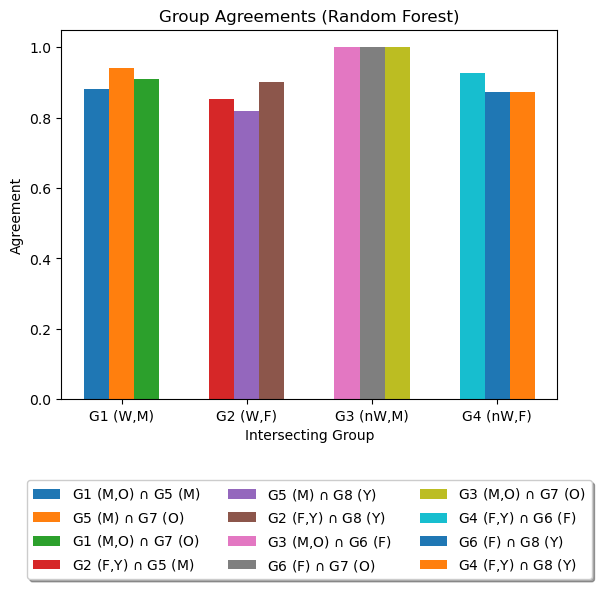

In [33]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, rf_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, rf_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, rf_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, rf_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, rf_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, rf_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, rf_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, rf_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, rf_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, rf_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, rf_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, rf_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Random Forest)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err = {}
for g in range(num_groups):
    ada_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, ada_test_err[g], std_err(ada_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.235 (+/-0.04239988207530771; n=200)
group 1 (M,O): 0.23880597014925373 (+/-0.07366274069214661; n=67)
group 2 (F,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.2909090909090909 (+/-0.08660904671107604; n=55)
group 5 (M): 0.25 (+/-0.05412658773652741; n=128)
group 6 (F): 0.25 (+/-0.07216878364870322; n=72)
group 7 (O): 0.2261904761904762 (+/-0.06455494976987063; n=84)
group 8 (Y): 0.29310344827586204 (+/-0.05976878104551381; n=116)
group 0 (ALL): 0.235 (+/-0.04239988207530771; n=200)
group 1 (M,O): 0.23880597014925373 (+/-0.07366274069214661; n=67)
group 2 (F,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (M,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.2909090909090909 (+/-0.08660904671107604; n=55)
group 5 (M): 0.25 (+/-0.05412658773652741; n=128)
group 6 (F): 0.25 (+/-0.07216878364870322; n=72)
group 7 (O): 0.2261904761904762 (+/-0.064554

In [36]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(M,O, M) agreement on G1 (M,O):	0.9253731343283582
(M, O) agreement on G1 (M,O):	0.9253731343283582
(M,O, O) agreement on G1 (M,O):	0.9701492537313433
(F,Y, M) agreement on G2 (F,Y):	0.7540983606557377
(M, Y) agreement on G2 (F,Y):	0.8032786885245902
(F,Y, Y) agreement on G2 (F,Y):	0.8852459016393442
(M,O, F) agreement on G3 (M,O):	1.0
(F, O) agreement on G3 (M,O):	1.0
(M,O, O) agreement on G3 (M,O):	1.0
(F,Y, F) agreement on G4 (F,Y):	0.8727272727272727
(F, Y) agreement on G4 (F,Y):	0.7818181818181819
(F,Y, Y) agreement on G4 (F,Y):	0.7636363636363637

(ALL, M,O) agreement:	0.875
(ALL, F,Y) agreement:	0.84
(ALL, M,O) agreement:	0.76
(ALL, F,Y) agreement:	0.76
(ALL, M) agreement:	0.935
(ALL, F) agreement:	0.86
(ALL, O) agreement:	0.895
(ALL, Y) agreement:	0.87


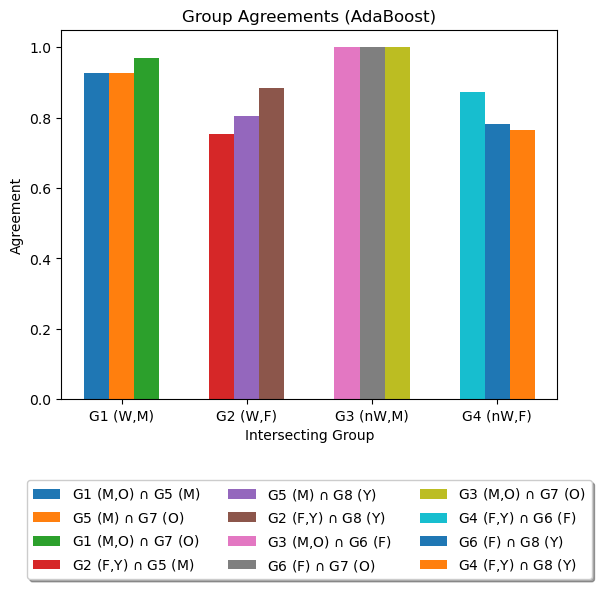

In [37]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, ada_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, ada_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, ada_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, ada_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, ada_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, ada_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, ada_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, ada_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, ada_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, ada_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, ada_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, ada_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# All Together

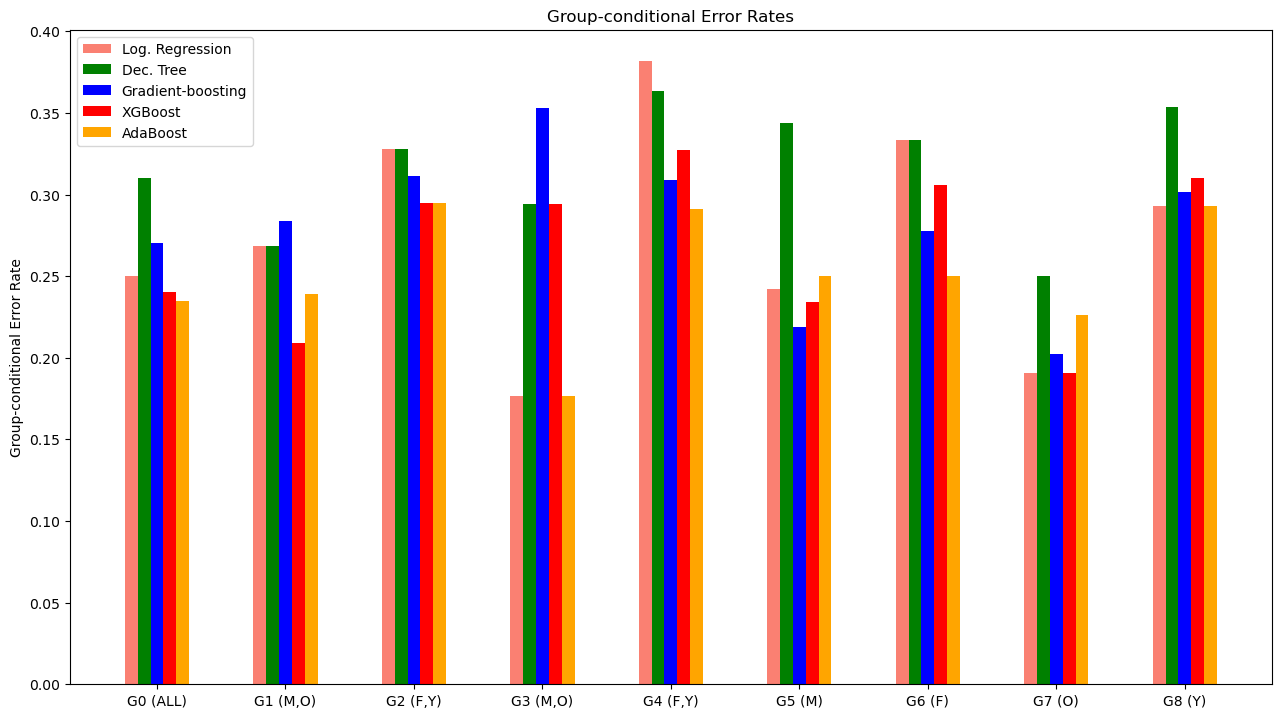

In [38]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, label="Log. Regression", color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, label="Dec. Tree", color="green")
        ax.bar(g, gb_test_err[g], bar_width, label="Gradient-boosting", color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, label="XGBoost", color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, color="green")
        ax.bar(g, gb_test_err[g], bar_width, color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

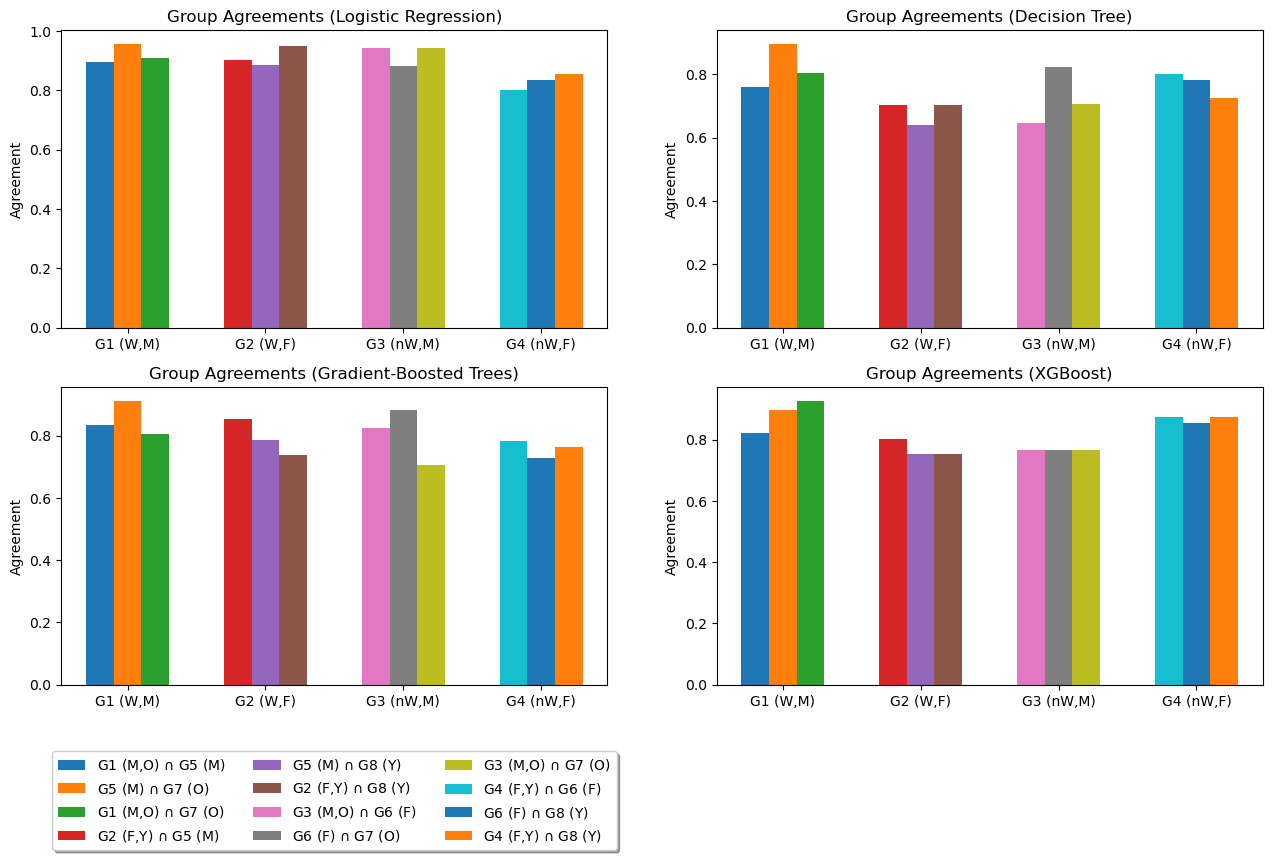

In [39]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
rect11 = ax[0][0].bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][0].bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][0].bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][0].bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][0].bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][0].bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][0].bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][0].bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][0].bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][0].bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][0].bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][0].bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# DECISION TREE
rect11 = ax[0][1].bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][1].bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][1].bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][1].bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][1].bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][1].bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][1].bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][1].bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][1].bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][1].bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][1].bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][1].bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][1].set_ylabel('Agreement')
ax[0][1].set_title('Group Agreements (Decision Tree)')
ax[0][1].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# GRADIENT-BOOSTED TREES
rect11 = ax[1][0].bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][0].bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][0].bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][0].bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][0].bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][0].bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][0].bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][0].bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][0].bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][0].bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][0].bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][0].bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# XGBOOST
rect11 = ax[1][1].bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][1].bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][1].bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][1].bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][1].bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][1].bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][1].bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][1].bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][1].bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][1].bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][1].bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][1].bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()